In [24]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
df = pd.read_csv("/content/ai_human_content_detection_dataset(in).csv")
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,text_content,content_type,label
0,Score each cause. Quality throughout beautiful...,academic_paper,1
1,Board its rock. Job worker break tonight coupl...,essay,1
2,Way debate decision produce. Dream necessary c...,academic_paper,1
3,Story turn because such during open model. Tha...,creative_writing,1
4,Place specific as simply leader fall analysis....,news_article,1


# Preprocessing

In [25]:
df.isna().sum()

,0
text_content,0
content_type,0
label,0


In [26]:
df.dropna()

,text_content,content_type,label
0,Score each cause. Quality throughout beautiful...,academic_paper,1
1,Board its rock. Job worker break tonight coupl...,essay,1
2,Way debate decision produce. Dream necessary c...,academic_paper,1
3,Story turn because such during open model. Tha...,creative_writing,1
4,Place specific as simply leader fall analysis....,news_article,1
...,...,...,...
1362,Congress month from thought instead anything. ...,academic_paper,0
1363,Learn lead reveal great action. Left theory pa...,article,0
1364,Third few low hard peace paper pass front. Mea...,social_media,0
1365,Power word west very news. Truth action base p...,blog_post,0


In [27]:
df.drop_duplicates

<bound method DataFrame.drop_duplicates of                                            text_content      content_type  \
0     Score each cause. Quality throughout beautiful...    academic_paper   
1     Board its rock. Job worker break tonight coupl...             essay   
2     Way debate decision produce. Dream necessary c...    academic_paper   
3     Story turn because such during open model. Tha...  creative_writing   
4     Place specific as simply leader fall analysis....      news_article   
...                                                 ...               ...   
1362  Congress month from thought instead anything. ...    academic_paper   
1363  Learn lead reveal great action. Left theory pa...           article   
1364  Third few low hard peace paper pass front. Mea...      social_media   
1365  Power word west very news. Truth action base p...         blog_post   
1366  Beyond card must former. Leave where join kind...         blog_post   

      label  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
1362      0  
1363      0  
1364      0  
1365      0  
1366      0  

[1367 rows x 3 columns]>

In [28]:
def preprocess_text(text):

    text = text.lower()# this code converts the text to lower case


    tokens = nltk.word_tokenize(text)# this code tokenizes and creates tokens from the text
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back into a string
    return ' '.join(tokens) #this is something i saw online that is necessary for human readability

# Apply preprocessing to the text_content column
df['processed_text'] = df['text_content'].apply(preprocess_text)

display(df[['text_content', 'processed_text']].head())

,text_content,processed_text
0,Score each cause. Quality throughout beautiful...,score caus . qualiti throughout beauti instead...
1,Board its rock. Job worker break tonight coupl...,board rock . job worker break tonight coupl . ...
2,Way debate decision produce. Dream necessary c...,way debat decis produc . dream necessari choos...
3,Story turn because such during open model. Tha...,stori turn open model . second develop singl b...
4,Place specific as simply leader fall analysis....,place specif simpli leader fall analysi . thou...


# Task 1 calculating tfidf vectors

In [29]:
# Calculate TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # Limiting to top 1000 features for simplicity
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (1367, 840)


In [30]:
# Strategy to determine top keywords: Sum TF-IDF scores for each word within each class

# Separate TF-IDF matrix by class
# Convert the boolean Series to a numpy array for indexing sparse matrix,
#Scikit-learn sparse matrices only support positional NumPy-style indexing, not pandas  objects.
tfidf_matrix_class_0 = tfidf_matrix[np.array(df['label'] == 0)] # Human-generated
tfidf_matrix_class_1 = tfidf_matrix[np.array(df['label'] == 1)] # AI-generated

# Sum TF-IDF scores for each feature (word) within each class and convert to dense array
sum_tfidf_class_0 = np.sum(tfidf_matrix_class_0, axis=0).A1 # .A1 converts to a 1D numpy array
sum_tfidf_class_1 = np.sum(tfidf_matrix_class_1, axis=0).A1 # .A1 converts to a 1D numpy array

# Get the indices of the top 10 features for each class
top_10_indices_class_0 = np.argsort(sum_tfidf_class_0)[::-1][:10]
top_10_indices_class_1 = np.argsort(sum_tfidf_class_1)[::-1][:10]

# Get the actual keywords and their summed TF-IDF scores
top_10_keywords_class_0 = [(feature_names[i], sum_tfidf_class_0[i]) for i in top_10_indices_class_0]
top_10_keywords_class_1 = [(feature_names[i], sum_tfidf_class_1[i]) for i in top_10_indices_class_1]

print("Top 10 keywords for Human-generated content (Label 0):")
for keyword, score in top_10_keywords_class_0:
    print(f"{keyword}: {score:.4f}")

print("\nTop 10 keywords for AI-generated content (Label 1):")
for keyword, score in top_10_keywords_class_1:
    print(f"{keyword}: {score:.4f}")

Top 10 keywords for Human-generated content (Label 0):
manag: 17.4649
posit: 12.7141
meet: 12.6721
nation: 12.6522
recent: 12.5365
feel: 12.5099
includ: 12.5003
even: 12.4303
democrat: 12.4239
author: 12.3353

Top 10 keywords for AI-generated content (Label 1):
manag: 16.6425
success: 13.5139
major: 13.4200
respons: 13.3832
product: 13.3535
like: 13.3218
polit: 13.1748
cultur: 13.0283
feel: 12.9523
develop: 12.7959


**Justification of the strategy:**

The method picks top keywords for each class by adding up TF-IDF scores for every word inside that class. TF-IDF is a way to measure how important a word is: it gets higher when a word shows up a lot in one document but not much in others. By summing TF-IDF for the same word across all documents in one class (Human or AI), we get a single score that says how important that word is for that class overall. Bigger sums mean the word is more typical of that class.
This works well because it cares about both how often a word appears and how special it is to that class. It also gives a clear number so you can rank words from most to least important. And it’s easy to explain: add the scores and sort.
When you look at the keywords, the human class (label 0) will tend to show words that match natural human topics and style in this dataset. The AI class (label 1) will tend to show words and phrases that the model repeats more, or patterns that reflect how it generates text. To learn more, you’d examine the exact words in each list and compare them to see which ones truly separate human from AI writing.

# Task 2 creating graph

In [31]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=df.index)
df_combined = pd.concat([df, tfidf_df], axis=1)
display(df_combined.head())

,text_content,content_type,label,processed_text,abil,abl,accept,accord,account,across,...,would,write,writer,wrong,yard,ye,yeah,year,yet,young
0,Score each cause. Quality throughout beautiful...,academic_paper,1,score caus . qualiti throughout beauti instead...,0.000000,0.0,0.0,0.055903,0.057028,0.0,...,0.000000,0.000000,0.057134,0.0,0.0,0.0,0.00000,0.0,0.000000,0.055220
1,Board its rock. Job worker break tonight coupl...,essay,1,board rock . job worker break tonight coupl . ...,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.061256,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000
2,Way debate decision produce. Dream necessary c...,academic_paper,1,way debat decis produc . dream necessari choos...,0.000000,0.0,0.0,0.000000,0.043100,0.0,...,0.042175,0.044090,0.043180,0.0,0.0,0.0,0.04225,0.0,0.000000,0.041734
3,Story turn because such during open model. Tha...,creative_writing,1,stori turn open model . second develop singl b...,0.069123,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.070186,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000
4,Place specific as simply leader fall analysis....,news_article,1,place specif simpli leader fall analysi . thou...,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.076744,0.073760


In [32]:
top_keywords_by_group = {}

grouped = df_combined.groupby(['content_type', 'label'])

for name, group in grouped:
    # Select only the TF-IDF columns
    tfidf_group = group[feature_names]

    # Sum TF-IDF scores for each word in the group
    sum_tfidf_group = tfidf_group.sum(axis=0)

    # Get the indices of the top 50 words
    top_50_indices = sum_tfidf_group.nlargest(50).index

    # Get the actual keywords
    top_50_keywords = top_50_indices.tolist()

    # Store in the dictionary
    top_keywords_by_group[name] = top_50_keywords

# Display a sample of the results
print("Sample of top keywords for each group:")
for group_name, keywords in list(top_keywords_by_group.items())[:3]: # Display first 3 groups
    print(f"\nGroup: {group_name}")
    print(f"Top 50 keywords: {keywords[:10]}...") # Display first 10 keywords for brevity

Sample of top keywords for each group:

Group: ('academic_paper', np.int64(0))
Top 50 keywords: ['manag', 'even', 'interest', 'meet', 'feel', 'polit', 'major', 'respons', 'includ', 'posit']...

Group: ('academic_paper', np.int64(1))
Top 50 keywords: ['nation', 'develop', 'polit', 'mr', 'cultur', 'interest', 'manag', 'democrat', 'major', 'like']...

Group: ('article', np.int64(0))
Top 50 keywords: ['manag', 'coach', 'exampl', 'includ', 'nation', 'sometim', 'talk', 'polit', 'ten', 'natur']...


In [33]:
nodes = list(top_keywords_by_group.keys())
print("List of nodes:")
print(nodes)

List of nodes:
[('academic_paper', np.int64(0)), ('academic_paper', np.int64(1)), ('article', np.int64(0)), ('article', np.int64(1)), ('blog_post', np.int64(0)), ('blog_post', np.int64(1)), ('creative_writing', np.int64(0)), ('creative_writing', np.int64(1)), ('essay', np.int64(0)), ('essay', np.int64(1)), ('news_article', np.int64(0)), ('news_article', np.int64(1)), ('product_review', np.int64(0)), ('product_review', np.int64(1)), ('social_media', np.int64(0)), ('social_media', np.int64(1))]


In [34]:
import networkx as nx
import itertools

# 1. Initialize an empty graph
graph = nx.Graph()

# 2. Iterate through all unique pairs of nodes
for node1, node2 in itertools.combinations(nodes, 2):
    # 3. Get the top keywords for each node
    keywords1 = set(top_keywords_by_group[node1])
    keywords2 = set(top_keywords_by_group[node2])

    # 4. Find the intersection of the two sets of keywords
    shared_keywords = keywords1.intersection(keywords2)

    # 5. If the number of shared keywords is greater than 0, add an edge
    num_shared_keywords = len(shared_keywords)
    if num_shared_keywords > 0:
        graph.add_edge(node1, node2, weight=num_shared_keywords)

# Print the number of nodes and edges in the graph
print(f"Number of nodes in the graph: {graph.number_of_nodes()}")
print(f"Number of edges in the graph: {graph.number_of_edges()}")

# Display some edges and their weights
print("\nSample edges and weights:")
for u, v, data in graph.edges(data=True):
    print(f"({u}) -- ({v}) : Weight = {data['weight']}")
    if len(graph.edges) > 10: # Limit sample output
        break

Number of nodes in the graph: 16
Number of edges in the graph: 120

Sample edges and weights:
(('academic_paper', np.int64(0))) -- (('academic_paper', np.int64(1))) : Weight = 23


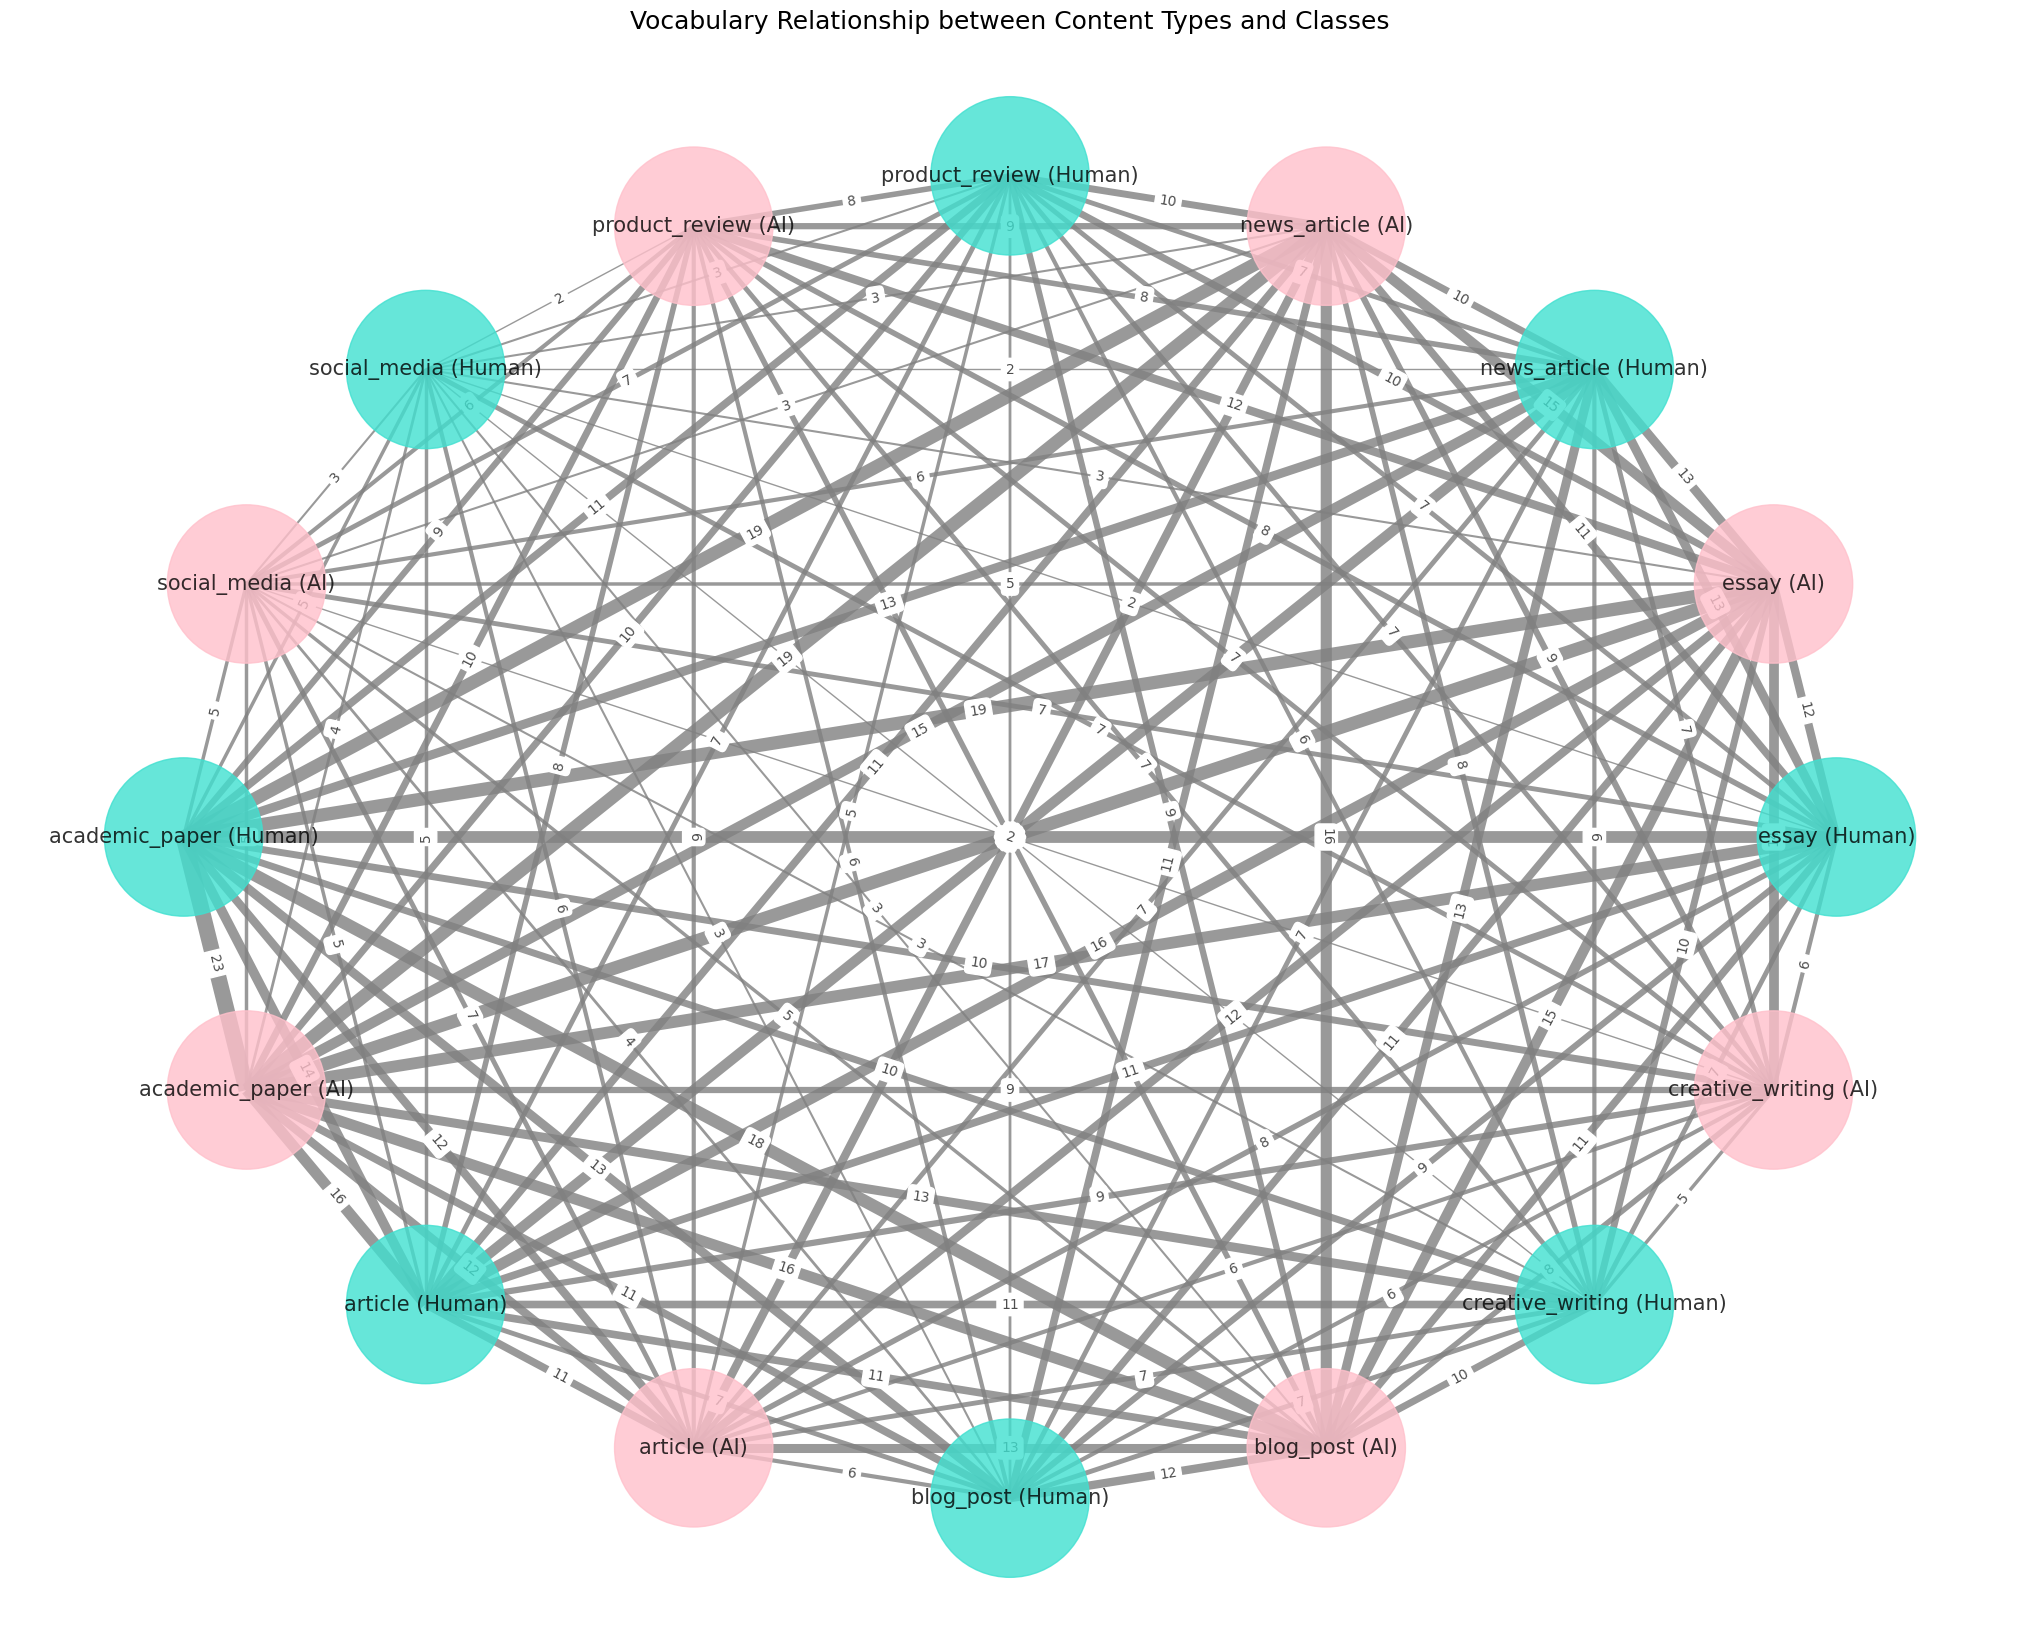

In [59]:
# Create a list of node colors
node_colors = ['turquoise' if node[1] == 0 else 'pink' for node in graph.nodes()]

# Create a dictionary of node labels
node_labels = {node: f"{node[0]} ({'Human' if node[1] == 0 else 'AI'})" for node in graph.nodes()}

# Create a list of edge widths based on weight
edge_widths = [data['weight'] for u, v, data in graph.edges(data=True)]

# Scale edge widths for better visualization if necessary (optional)
# For example, scale by a factor:
scaled_edge_widths = [w * 0.5 for w in edge_widths] # Further adjusted scaling factor

# Draw the graph
plt.figure(figsize=(20, 16)) # Significantly increased figure size
layout=nx.shell_layout(graph)
nx.draw(graph, layout,
        with_labels=True,
        labels=node_labels,
        node_color=node_colors,
        node_size=13000,
        edge_color='gray',
        width=scaled_edge_widths,
        font_size=15,
        font_color='black',
        alpha=0.8)

# Add edge labels (weights)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, layout, edge_labels=edge_labels, font_size=10, alpha=0.7)


plt.title("Vocabulary Relationship between Content Types and Classes", size=18) # Increased title size
plt.show()



 Analysis and findings

 We found the top 50 important words for every mix of content type and writer (human or AI). Then we built a network with 16 dots, one for each mix. There are 120 lines connecting them, which means every pair shares at least one word from their top 50 lists. The lines don’t all have the same strength. For example, human academic papers and AI academic papers share 23 words, so that link is strong. In the picture, human dots are blue and AI dots are red, and thicker lines mean more shared words. Words are shared within human writing across different types and within AI writing across different types. Humans and AI also share words with each other, both within the same type and across different types, but the amount of overlap changes from pair to pair.
This tells us that human and AI writing are different in some ways, but they also overlap a lot, especially inside the same content types. A good next step is to look closely at which words are shared to understand why. It would also help to study how strong the lines are overall to see which content types are the most different between human and AI writing, and which ones look most similar no matter who wrote them.

# Task 3 dimensality reduction, and clusteirng

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA for dimensionality reduction
# Reducing to 50 components as an initial step
pca = PCA(n_components=50)
tfidf_pca = pca.fit_transform(tfidf_matrix)

print("Original TF-IDF matrix shape:", tfidf_matrix.shape)
print("PCA reduced matrix shape:", tfidf_pca.shape)

# Apply t-SNE for dimensionality reduction (often used for visualization)
# Reducing to 2 components for visualization
tsne = TSNE(n_components=2, random_state=42, init='random') # Changed init to 'random'
tfidf_tsne = tsne.fit_transform(tfidf_matrix)

print("t-SNE reduced matrix shape:", tfidf_tsne.shape)

Original TF-IDF matrix shape: (1367, 840)
PCA reduced matrix shape: (1367, 50)
t-SNE reduced matrix shape: (1367, 2)


In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.decomposition import PCA # Import PCA for consistent dimensionality reduction

# Apply K-Means clustering to the PCA reduced data (50 components)
# Retrain KMeans on the PCA-transformed data
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(tfidf_pca) # Use tfidf_pca which has 50 features

print("K-Means cluster labels shape:", kmeans_labels.shape)
print("K-Means cluster labels (first 10):", kmeans_labels[:10])

# Evaluate K-Means clustering performance using various metrics on the PCA data
silhouette_avg_kmeans = silhouette_score(tfidf_pca, kmeans_labels)
ami_score_kmeans = adjusted_mutual_info_score(df['label'], kmeans_labels)
ari_score_kmeans = adjusted_rand_score(df['label'], kmeans_labels)
ch_score_kmeans = calinski_harabasz_score(tfidf_pca, kmeans_labels)


print(f"\nSilhouette Score for K-Means (on PCA data): {silhouette_avg_kmeans:.4f}")
print(f"Adjusted Mutual Information (AMI) for K-Means (on PCA data): {ami_score_kmeans:.4f}")
print(f"Adjusted Rand Index (ARI) for K-Means (on PCA data): {ari_score_kmeans:.4f}")
print(f"Calinski-Harabasz (CH) Index for K-Means (on PCA data): {ch_score_kmeans:.4f}")

K-Means cluster labels shape: (1367,)
K-Means cluster labels (first 10): [1 1 1 1 1 1 0 1 1 1]

Silhouette Score for K-Means (on PCA data): 0.0777
Adjusted Mutual Information (AMI) for K-Means (on PCA data): -0.0001
Adjusted Rand Index (ARI) for K-Means (on PCA data): -0.0001
Calinski-Harabasz (CH) Index for K-Means (on PCA data): 92.2917


DBSCAN cluster labels shape: (1367,)
DBSCAN cluster labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Number of unique DBSCAN labels: [-1  0  1  2  3  4  5  6]


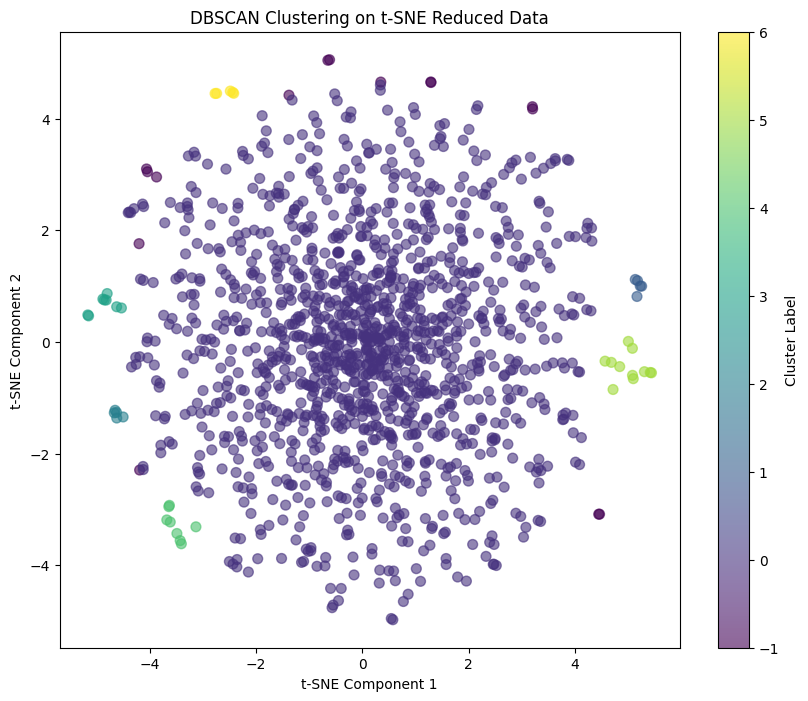

Silhouette Score for DBSCAN clustering (excluding noise): 0.0332
Calinski-Harabasz (CH) Index for DBSCAN: 24.4226
Adjusted Mutual Information (AMI) for DBSCAN (excluding noise): -0.0021
Adjusted Rand Index (ARI) for DBSCAN (excluding noise): -0.0001


In [38]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

# Apply DBSCAN clustering to the t-SNE reduced data
# You might need to tune the eps and min_samples parameters based on the data
dbscan = DBSCAN(eps=0.5, min_samples=5) # Example parameters, may need tuning
dbscan_labels = dbscan.fit_predict(tfidf_tsne)

print("DBSCAN cluster labels shape:", dbscan_labels.shape)
print("DBSCAN cluster labels (first 10):", dbscan_labels[:10])
print("Number of unique DBSCAN labels:", np.unique(dbscan_labels)) # -1 indicates noise points

# Visualize DBSCAN clusters in t-SNE reduced space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('DBSCAN Clustering on t-SNE Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Evaluate DBSCAN clustering performance using various metrics
# Silhouette score is not well-defined for a single cluster, or when there are no points assigned to clusters
if len(np.unique(dbscan_labels)) > 1 and -1 in dbscan_labels and len(np.unique(dbscan_labels)) > 2:
    silhouette_avg_dbscan = silhouette_score(tfidf_tsne[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Silhouette Score for DBSCAN clustering (excluding noise): {silhouette_avg_dbscan:.4f}")
elif len(np.unique(dbscan_labels)) > 1 and -1 not in dbscan_labels:
     silhouette_avg_dbscan = silhouette_score(tfidf_tsne, dbscan_labels)
     print(f"Silhouette Score for DBSCAN clustering: {silhouette_avg_dbscan:.4f}")
else:
    print("Silhouette Score cannot be calculated for DBSCAN (too few clusters or only noise).")

# Calculate AMI, ARI, and CH for DBSCAN (excluding noise points)
# These metrics also require at least two clusters, and handle noise points differently
# For simplicity, we will exclude noise points (-1) for AMI and ARI as they are comparison metrics with ground truth
# CH index requires at least 2 clusters
if len(np.unique(dbscan_labels)) > 1 and len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1:
    # Filter out noise points for metrics that compare to ground truth
    non_noise_indices = dbscan_labels != -1
    ami_score_dbscan = adjusted_mutual_info_score(df['label'][non_noise_indices], dbscan_labels[non_noise_indices])
    ari_score_dbscan = adjusted_rand_score(df['label'][non_noise_indices], dbscan_labels[non_noise_indices])
    # CH index can be calculated on the full data if there are at least 2 clusters
    if len(np.unique(dbscan_labels)) > 1:
         ch_score_dbscan = calinski_harabasz_score(tfidf_tsne, dbscan_labels)
         print(f"Calinski-Harabasz (CH) Index for DBSCAN: {ch_score_dbscan:.4f}")
    else:
        print("Calinski-Harabasz (CH) Index cannot be calculated for DBSCAN (too few clusters).")

    print(f"Adjusted Mutual Information (AMI) for DBSCAN (excluding noise): {ami_score_dbscan:.4f}")
    print(f"Adjusted Rand Index (ARI) for DBSCAN (excluding noise): {ari_score_dbscan:.4f}")

elif len(np.unique(dbscan_labels)) > 1:
     # Case where there are no noise points but more than one cluster
     ami_score_dbscan = adjusted_mutual_info_score(df['label'], dbscan_labels)
     ari_score_dbscan = adjusted_rand_score(df['label'], dbscan_labels)
     if len(np.unique(dbscan_labels)) > 1:
         ch_score_dbscan = calinski_harabasz_score(tfidf_tsne, dbscan_labels)
         print(f"Calinski-Harabasz (CH) Index for DBSCAN: {ch_score_dbscan:.4f}")
     else:
        print("Calinski-Harabasz (CH) Index cannot be calculated for DBSCAN (too few clusters).")
     print(f"Adjusted Mutual Information (AMI) for DBSCAN: {ami_score_dbscan:.4f}")
     print(f"Adjusted Rand Index (ARI) for DBSCAN: {ari_score_dbscan:.4f}")

else:
    print("AMI, ARI, and CH scores cannot be calculated for DBSCAN (too few clusters or only noise).")

In [39]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score

# Apply Hierarchical Clustering (Agglomerative Clustering) to the t-SNE reduced data
# Choosing an arbitrary number of clusters (e.g., 2)
hierarchical = AgglomerativeClustering(n_clusters=2) # Example parameter, may need tuning
hierarchical_labels = hierarchical.fit_predict(tfidf_tsne)

print("Hierarchical Clustering labels shape:", hierarchical_labels.shape)
print("Hierarchical Clustering labels (first 10):", hierarchical_labels[:10])

# Evaluate Hierarchical clustering performance using various metrics
silhouette_avg_hierarchical = silhouette_score(tfidf_tsne, hierarchical_labels)
ami_score_hierarchical = adjusted_mutual_info_score(df['label'], hierarchical_labels)
ari_score_hierarchical = adjusted_rand_score(df['label'], hierarchical_labels)
ch_score_hierarchical = calinski_harabasz_score(tfidf_tsne, hierarchical_labels)

print(f"\nSilhouette Score for Hierarchical clustering: {silhouette_avg_hierarchical:.4f}")
print(f"Adjusted Mutual Information (AMI) for Hierarchical clustering: {ami_score_hierarchical:.4f}")
print(f"Adjusted Rand Index (ARI) for Hierarchical clustering: {ari_score_hierarchical:.4f}")
print(f"Calinski-Harabasz (CH) Index for Hierarchical clustering: {ch_score_hierarchical:.4f}")

Hierarchical Clustering labels shape: (1367,)
Hierarchical Clustering labels (first 10): [1 0 1 0 0 0 1 0 0 1]

Silhouette Score for Hierarchical clustering: 0.2762
Adjusted Mutual Information (AMI) for Hierarchical clustering: 0.0001
Adjusted Rand Index (ARI) for Hierarchical clustering: 0.0002
Calinski-Harabasz (CH) Index for Hierarchical clustering: 581.9805


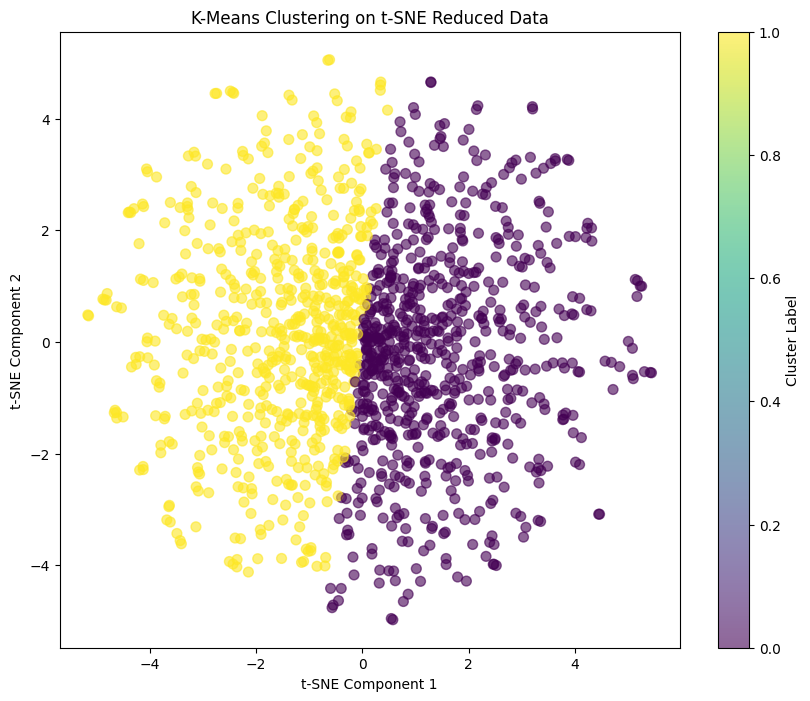

Silhouette Score for K-Means clustering: 0.2905


In [40]:
# Visualize K-Means clusters in t-SNE reduced space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-Means Clustering on t-SNE Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Evaluate K-Means clustering performance using Silhouette score
silhouette_avg_kmeans = silhouette_score(tfidf_tsne, kmeans_labels)
print(f"Silhouette Score for K-Means clustering: {silhouette_avg_kmeans:.4f}")

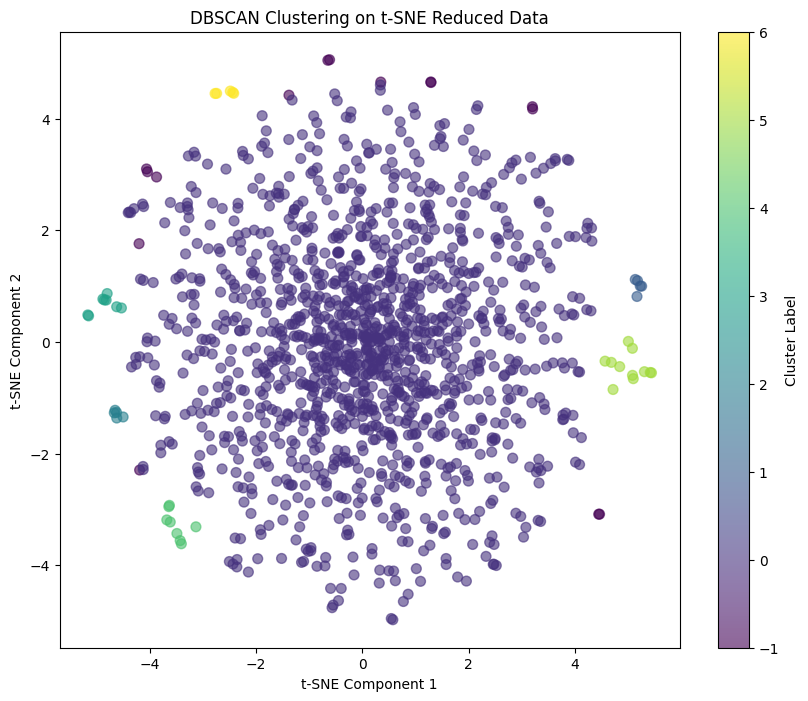

Silhouette Score for DBSCAN clustering (excluding noise): 0.0332


In [41]:
# Visualize DBSCAN clusters in t-SNE reduced space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('DBSCAN Clustering on t-SNE Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Evaluate DBSCAN clustering performance using Silhouette score (excluding noise points)
# Silhouette score is not well-defined for a single cluster, or when there are no points assigned to clusters
if len(np.unique(dbscan_labels)) > 1 and -1 in dbscan_labels and len(np.unique(dbscan_labels)) > 2:
    silhouette_avg_dbscan = silhouette_score(tfidf_tsne[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Silhouette Score for DBSCAN clustering (excluding noise): {silhouette_avg_dbscan:.4f}")
elif len(np.unique(dbscan_labels)) > 1 and -1 not in dbscan_labels:
     silhouette_avg_dbscan = silhouette_score(tfidf_tsne, dbscan_labels)
     print(f"Silhouette Score for DBSCAN clustering: {silhouette_avg_dbscan:.4f}")
else:
    print("Silhouette Score cannot be calculated for DBSCAN (too few clusters or only noise).")

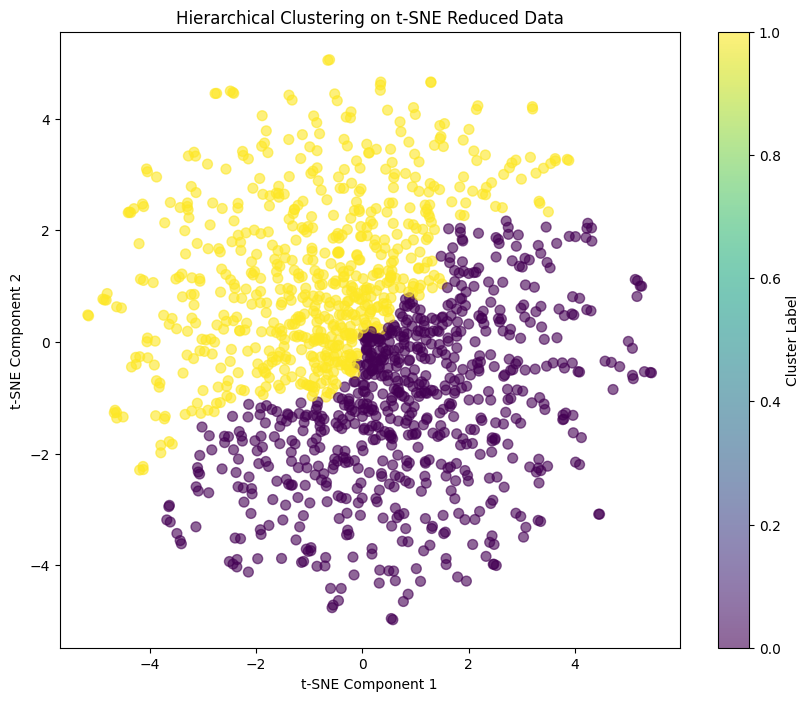

Silhouette Score for Hierarchical clustering: 0.2762


In [42]:
# Visualize Hierarchical clusters in t-SNE reduced space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=hierarchical_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('Hierarchical Clustering on t-SNE Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Evaluate Hierarchical clustering performance using Silhouette score
silhouette_avg_hierarchical = silhouette_score(tfidf_tsne, hierarchical_labels)
print(f"Silhouette Score for Hierarchical clustering: {silhouette_avg_hierarchical:.4f}")

## Clustering Performance Comparison and Interpretation

Based on the visualizations and the Silhouette scores:

K-Means: Two main groups (left vs. right) are visible, but many points mix in the middle. Silhouette ≈ 0.2905  weak-to-okay separation.

DBSCAN: Most points fell into one big cluster, with a few tiny groups and some noise points. Silhouette ≈ 0.0332  almost no real separation. DBSCAN is very sensitive to its settings.

Hierarchical Clustering: Again two main groups with overlap in the center. Silhouette ≈ 0.2762, similar to K-Means but a bit worse; clusters are there but not tight.

Overall: K-Means ≈ Hierarchical (both modest) then DBSCAN (poor).

# TASK 4


Enter the text you want to analyze: ai healthcare ai healthcare sick health artificial
Step a: Preprocessing and Vectorizing new text...
Preprocessing and Vectorization Complete.

Applying PCA to new text vector...
PCA transformation complete.

Step b: Applying clustering model...
Predicted cluster label: 0

Step c: Mapping to content type...
Most likely content type: social_media

Step d: Computing cosine similarity and building graph...
Built graph with 11 nodes and 2 edges.

Step e: Applying graph analysis...
Graph analysis complete.

Step f: Visualizing and reporting results...
Results
Predicted Cluster Label: 0
Most Likely Content Type: social_media

Graph Analysis


,Degree Centrality,Betweenness Centrality,Closeness Centrality,PageRank
New Text,0.2,0.022222,0.200000,0.347493
Doc 1339,0.1,0.000000,0.133333,0.192043
Doc 61,0.1,0.000000,0.133333,0.174750
Doc 1189,0.0,0.000000,0.000000,0.035714
Doc 527,0.0,0.000000,0.000000,0.035714
Doc 1081,0.0,0.000000,0.000000,0.035714
Doc 151,0.0,0.000000,0.000000,0.035714
Doc 377,0.0,0.000000,0.000000,0.035714
Doc 1353,0.0,0.000000,0.000000,0.035714
Doc 44,0.0,0.000000,0.000000,0.035714



Similarity Graph Visualization


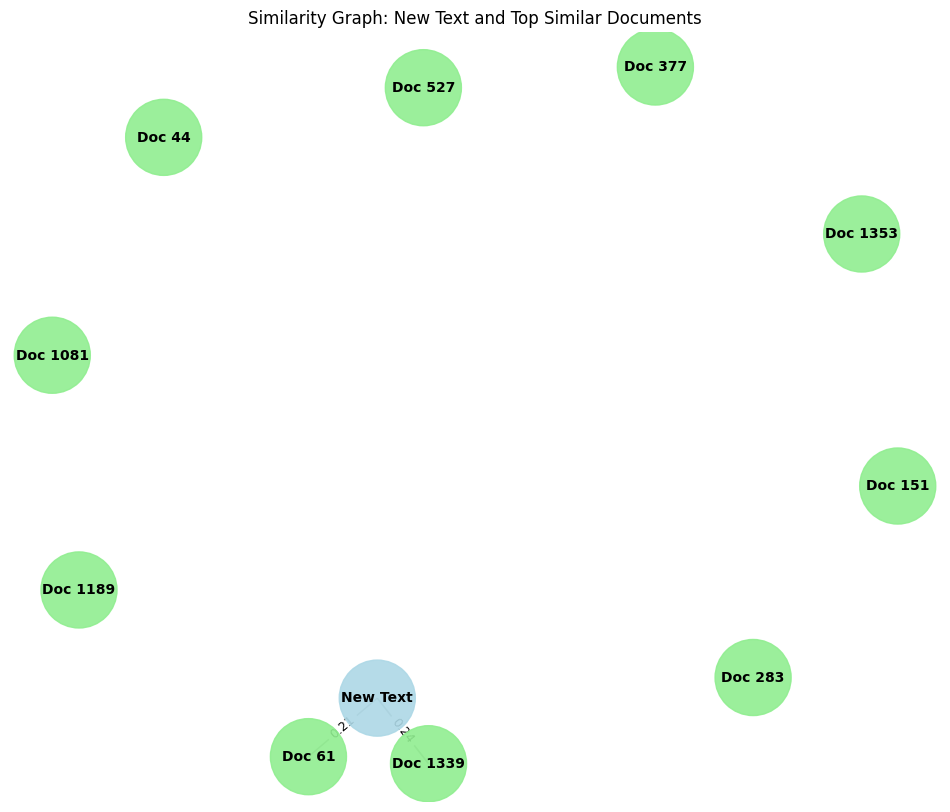

Visualization and reporting complete.


In [54]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

def preprocess_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    sw = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in sw]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

def preprocess_and_vectorize_text(text, vectorizer):
    return vectorizer.transform([preprocess_text(text)])

def map_cluster_to_content_type(cluster_label, df, clustering_labels):
    df_ = df.copy()
    df_['cluster'] = clustering_labels
    cdf = df_[df_['cluster'] == cluster_label]
    if cdf.empty:
        return "No content types found for this cluster."
    return cdf['content_type'].mode()[0]

def build_similarity_graph(new_text_vector, tfidf_matrix, df, k=10, similarity_threshold=0.2):
    sims = cosine_similarity(new_text_vector, tfidf_matrix).ravel()
    top_idx = sims.argsort()[::-1][:k]
    top_scores = sims[top_idx]
    G = nx.Graph()
    G.add_node("New Text")
    for i, s in zip(top_idx, top_scores):
        n = f"Doc {i}"
        G.add_node(n)
        if s > similarity_threshold:
            G.add_edge("New Text", n, weight=float(s))
    return G, top_idx.tolist(), top_scores.tolist()

def analyze_graph(graph):
    return pd.DataFrame({
        'Degree Centrality': pd.Series(nx.degree_centrality(graph)),
        'Betweenness Centrality': pd.Series(nx.betweenness_centrality(graph)),
        'Closeness Centrality': pd.Series(nx.closeness_centrality(graph)),
        'PageRank': pd.Series(nx.pagerank(graph))
    })

def visualize_and_report(cluster_label, content_type, graph, analysis_df):
    print("Results")
    print(f"Predicted Cluster Label: {cluster_label}")
    print(f"Most Likely Content Type: {content_type}")
    print("\nGraph Analysis")
    display(analysis_df)
    print("\nSimilarity Graph Visualization")
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(graph)
    node_colors = ['lightblue' if n == "New Text" else 'lightgreen' for n in graph.nodes()]
    nx.draw_networkx_nodes(graph, pos, node_size=3000, node_color=node_colors, alpha=0.9)
    edges = graph.edges(data=True)
    weights = [d['weight'] * 5 for _, _, d in edges]
    nx.draw_networkx_edges(graph, pos, edgelist=edges, width=weights, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges}, font_size=9)
    plt.title("Similarity Graph: New Text and Top Similar Documents")
    plt.axis('off')
    plt.show()

def analyze_text_content(new_text_input, tfidf_vectorizer, kmeans_model, original_df, original_clustering_labels, tfidf_matrix_original, pca_model, k=10, similarity_threshold=0.2):
    print("Step a: Preprocessing and Vectorizing new text...")
    new_vec = preprocess_and_vectorize_text(new_text_input, tfidf_vectorizer)
    print("Preprocessing and Vectorization Complete.")
    print("\nApplying PCA to new text vector...")
    new_vec_pca = pca_model.transform(new_vec)
    print("PCA transformation complete.")
    print("\nStep b: Applying clustering model...")
    predicted_cluster = kmeans_model.predict(new_vec_pca)[0]
    print(f"Predicted cluster label: {predicted_cluster}")
    print("\nStep c: Mapping to content type...")
    predicted_content_type = map_cluster_to_content_type(predicted_cluster, original_df, original_clustering_labels)
    print(f"Most likely content type: {predicted_content_type}")
    print("\nStep d: Computing cosine similarity and building graph...")
    graph, top_indices, top_scores = build_similarity_graph(new_vec, tfidf_matrix_original, original_df, k=k, similarity_threshold=similarity_threshold)
    print(f"Built graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    print("\nStep e: Applying graph analysis...")
    graph_analysis_results = analyze_graph(graph)
    print("Graph analysis complete.")
    print("\nStep f: Visualizing and reporting results...")
    visualize_and_report(predicted_cluster, predicted_content_type, graph, analysis_df=graph_analysis_results)
    print("Visualization and reporting complete.")

user_text = input("Enter the text you want to analyze: ")
analyze_text_content(user_text, tfidf_vectorizer, kmeans, df, kmeans_labels, tfidf_matrix, pca)